# OCR 판독기 만들기
기계가 글자를 읽을 수 있는가?

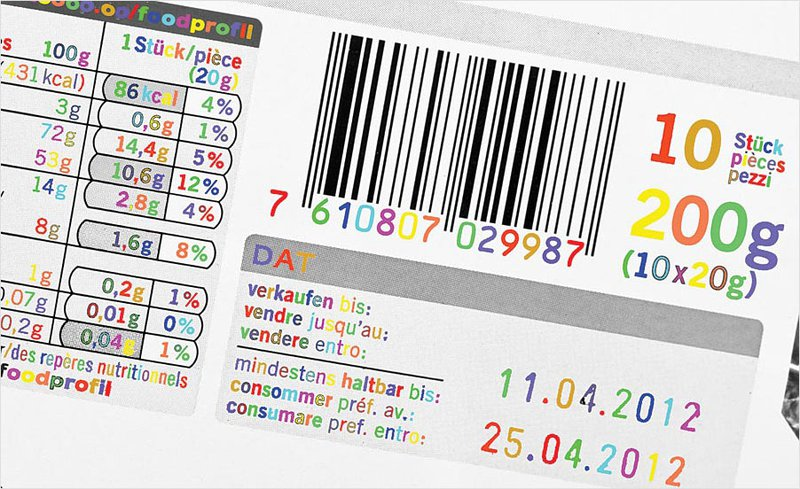
기계가 문자를 읽는 과정에는 Detection(문자 위치 인식), Recognition(어떤 문자인지 확인) 필요



구글 OCR API 사이트
https://cloud.google.com/vision
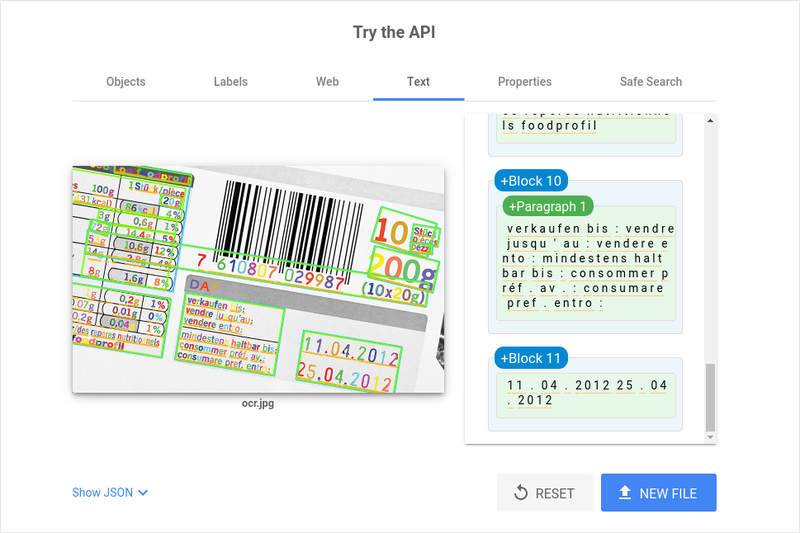
해당 사이트에서 문자 인식하는 페이지



## STEP 1) 구글의 파이썬 API 인터페이스 모듈을 아래와 설치


pip install --upgrade google-api-python-client


pip install google-cloud-vision

## STEP 2) Google Cloud Vision API 사용

서비스 계정 및 인증키 생성
https://kimchangheon.tistory.com/166

## STEP 3) API 사용 테스트

#### 사용할 사진
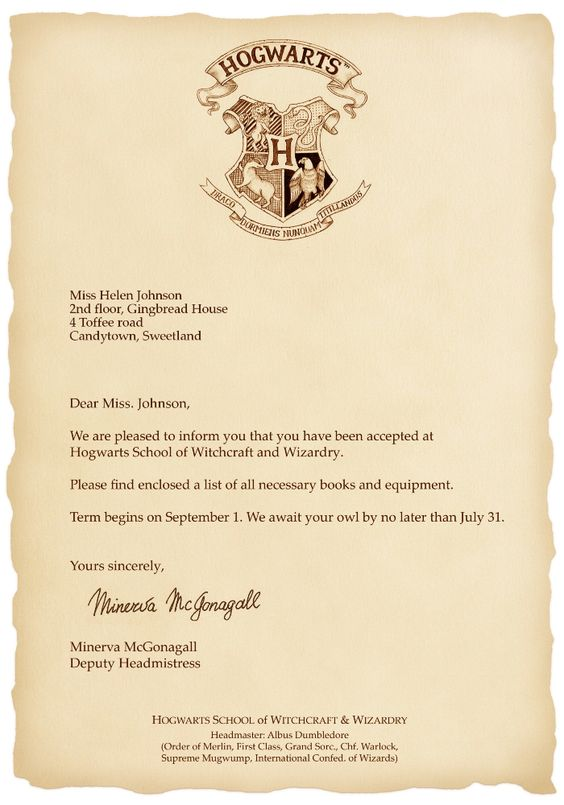

#### API 중 detect_text 가져오기

In [2]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
       print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [5]:
# 로컬 환경에서는 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
# 클라우드 환경에서는 무시해도 좋습니다
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'

# 입력 이미지 경로를 지정해 주세요.
path = os.getenv('HOME')+'/aiffel/ocr_python/test_image.png'
# path = # [[YOUR IMAGE FILE PATH]]   

# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
detect_text(path)

-rw-r--r-- 1 root root 2329 Feb 25 06:02 /aiffel/aiffel/ocr_python/my_google_api_key.json
Texts:

"HOGWARTS
LANCAS
NUNOA
IRACO
Miss Helen Johnson
2nd floor, Gingbread House
4 Toffee road
Candytown, Sweetland
Dear Miss. Johnson,
We are pleased to inform you that you have been acce
Hogwarts School of Witchcraft and Wizardry.
at
Please find enclosed a list of all necessary books and equipment.
Term begins on September 1. We await your owl by no later than July 31.
Yours sincerely,
Mineasta MeJenagall
Minerva McGonagall
Deputy Headmistress
HOGWARTS SCHOOL of WITCHCRAFT & WIZARDRY
Headmaster: Albus Dumbledore
(Order of Merlin, First Class, Grand Sorc., Chf. Warlock,
Supreme Mugwump, International Confed. of Wizards)
"

"HOGWARTS"

"LANCAS"

"NUNOA"

"IRACO"

"Miss"

"Helen"

"Johnson"

"2nd"

"floor,"

"Gingbread"

"House"

"4"

"Toffee"

"road"

"Candytown,"

"Sweetland"

"Dear"

"Miss."

"Johnson,"

"We"

"are"

"pleased"

"to"

"inform"

"you"

"that"

"you"

"have"

"been"

"acce"

"Hog

## 문자 인식 원리
글 API에서는 문자의 영역을 사각형으로 표현하고 우측에 Block과 Paragraph로 구분해서 인식 결과를 나타내고 있음

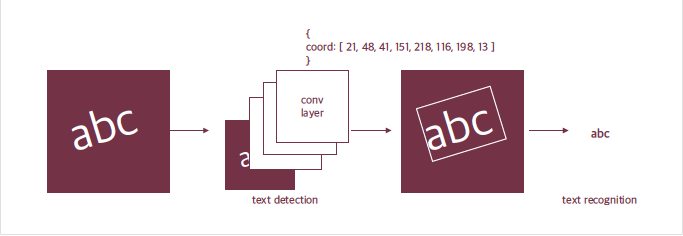

1. Text Detection(문자검출) : 먼저 입력받은 사진 속에서 문자의 위치를 찾아내기


2. Text Recognition(문자인식) : 찾은 문자 영역으로부터 문자를 읽어내는 것


위 그림에서는 문자의 영역을 표현하는 방법으로 사각형의 네 꼭짓점 좌표를 알려 주는 방법을 제시

## 딥러닝 문자인식의 시작
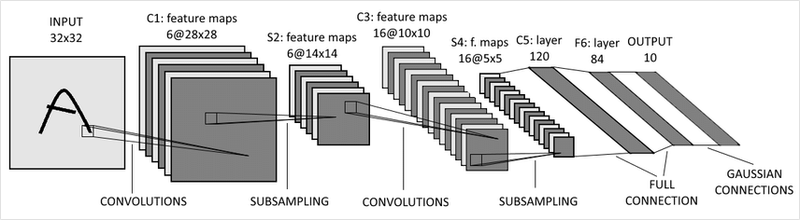
1998년에 발표된 LeNet이 MNIST를 이용하여 우편번호, 손글씨를 읽기 시작

CNN 구조로 구성


#### 입력과 각 Layer의 활성화를 시각화한 LeNet의 MNIST 데모 이미지
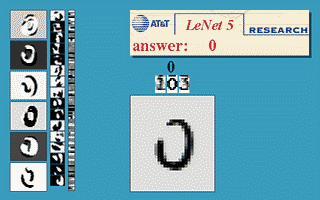
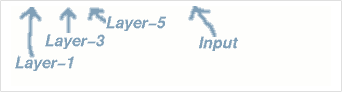

#### 장점, 한계

간단한 구조로도 어려운 글자 읽기 가능

넓고 복잡한 이미지에서 글자 영역을 찾을 수 없음 

글자를 영역별로 잘라서 넣더라도 우리가 인식하기를 원하는 사진은 여러 글자가 모여있기 때문에 단순한 분류 문제로 표현이 불가능

## 사진 속 문자 찾아내기 - detection
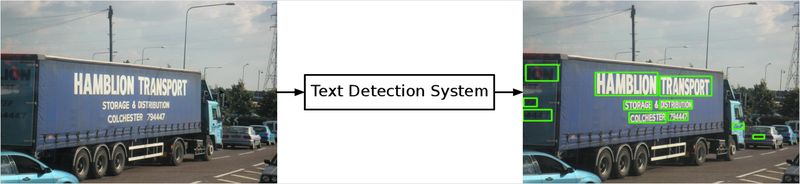
사진 속 문자를 찾아내는 최근의 딥러닝 모델은 일반적인 Object Detection(객체 인식) 방법으로 접근(물론 문자의 특성에 따라서 모델을 변경해 주기도 함)

### 문자 인식이 일반 객체 인식과 다른 점
- 일반적인 객체는 물체에 따라서 크기가 일정한 특징을 가진다. 하지만 문자는 영역과 배치가 자유로워 문자를 검출하기 위한 설정이 필요하다.



- 객체는 물체 간 거리가 충분히 확보되는 데에 반해 글자는 매우 촘촘하게 배치

#### 객체 인식
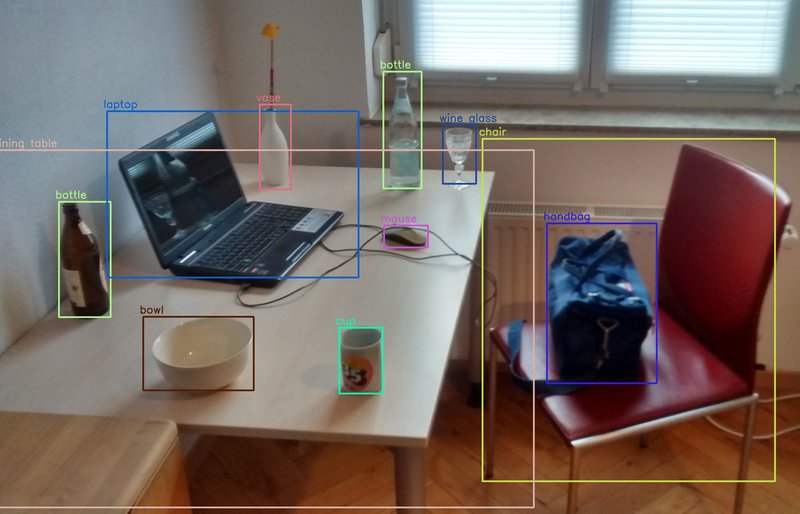

#### 문자 인식
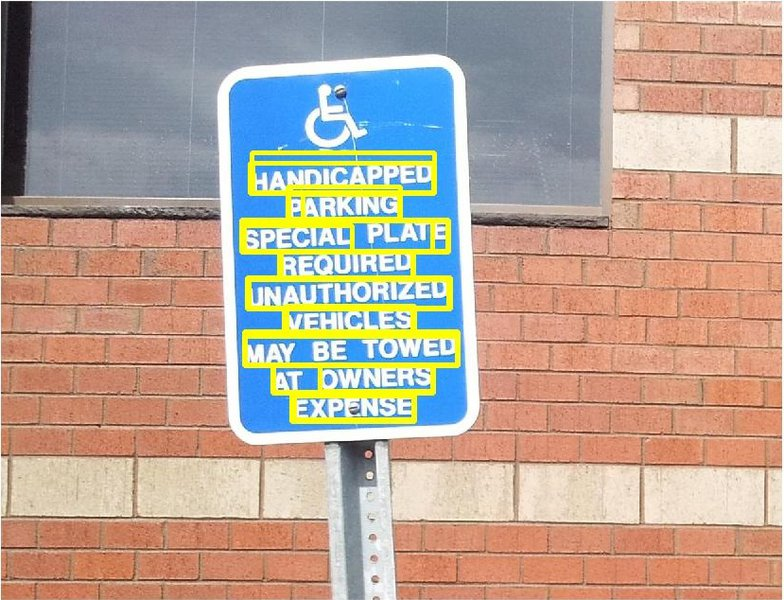

## 사진 속 문자 읽어내기 - recognition
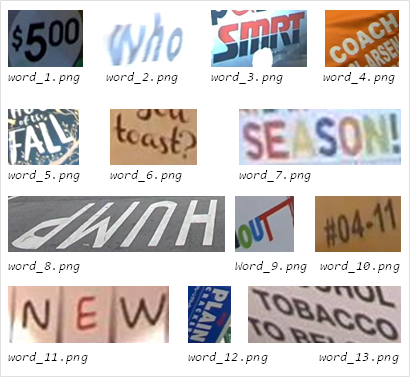
ICDAR15라는 OCR 데이터셋에서 단어 단위로 잘린 이미지 객체들



### CRNN - 대표적 OCR 방식
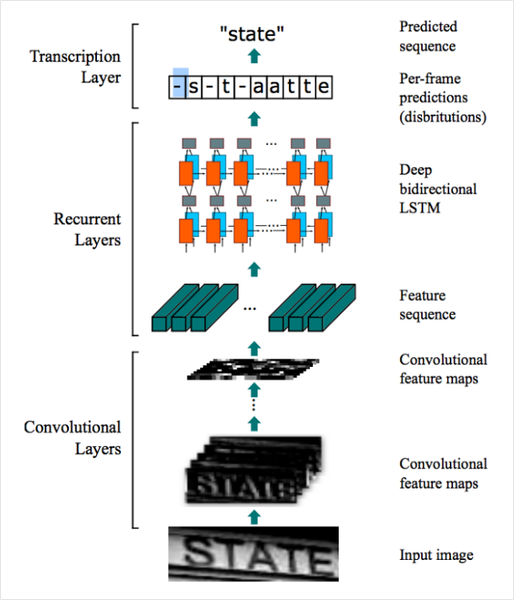
CNN + RNN 으로,  이미지 내의 텍스트와 연관된 특징을 CNN을 통해 추출한 후에 스텝 단위의 문자 정보를 RNN으로 인식하는 방식

이렇게 검출 결과로부터 인식 모델을 통해 문자를 인식하고 나면 구글 API의 결과처럼 사진 속 영역에 표시를 하고 그 영역에 어떤 문자가 적혀있는지 알 수 있는 OCR 시스템 됨

#### 네이버 OCR 팀 연구 성과 영상
https://tv.naver.com/v/4578167

# keras-ocr 써보기

- 검출 모델 : CRAFT(Character Region Awareness for Text Detection)를 사용


- 인식 모델 : CRNN



In [6]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [7]:
# 테스트에 사용할 이미지 url을 모아 봅니다. 추가로 더 모아볼 수도 있습니다. 
image_urls = [
  'https://source.unsplash.com/M7mu6jXlcns/640x460',
  'https://source.unsplash.com/6jsp4iHc8hI/640x460',
  'https://source.unsplash.com/98uYQ-KupiE',
  'https://source.unsplash.com/j9JoYpaJH3A',
  'https://source.unsplash.com/eBkEJ9cH5b4'
]

images = [ keras_ocr.tools.read(url) for url in image_urls]
prediction_groups = [pipeline.recognize([url]) for url in image_urls]

#### 시각화


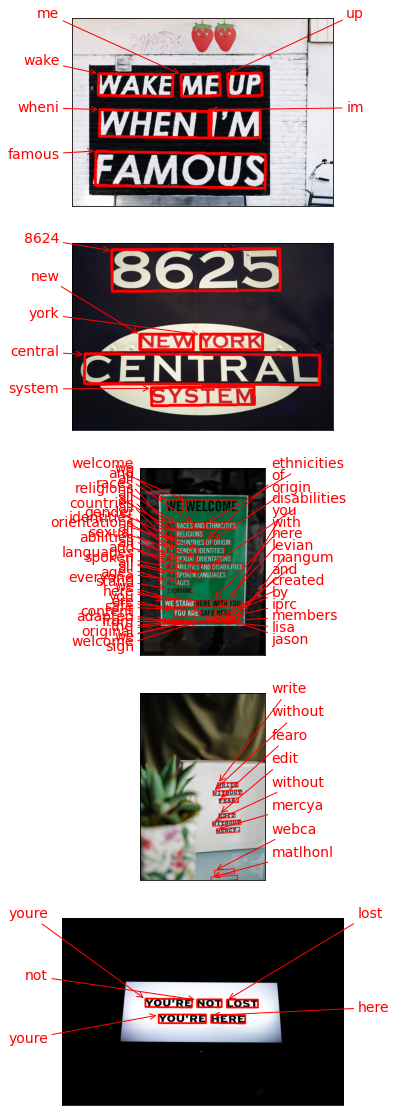

In [8]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

#### (주의사항)
keras-ocr은 한글 데이터셋으로 훈련이 되어있지 않은 모델

detection은 정상적으로 진행되더라도 recognition 결과가 엉뚱하게 나올 수 있음

# 테서랙트 써보기
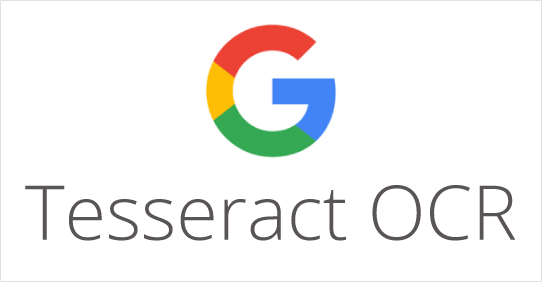
구글에서 후원하는 OCR 오픈소스 라이브러리

현재 한국어를 포함한 116 개 국어를 지원

터미널에서 테서랙트, 테서랙트 파이썬 wrapper 설치해야 함

###  테서랙트로 문자 검출하고 이미지 자르기 (detection)
테서랙트를 사용하면 한 번에 이미지 내의 문자 검출과 인식을 할 수 있음

In [9]:
# 검출 먼저 해보기
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list


work_dir = os.getenv('HOME')+'/aiffel/ocr_python'
img_file_path = work_dir + '/test_image.png'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

/aiffel/aiffel/ocr_python/0000.png
/aiffel/aiffel/ocr_python/0001.png
/aiffel/aiffel/ocr_python/0002.png
/aiffel/aiffel/ocr_python/0003.png
/aiffel/aiffel/ocr_python/0004.png
/aiffel/aiffel/ocr_python/0005.png
/aiffel/aiffel/ocr_python/0006.png
/aiffel/aiffel/ocr_python/0007.png
/aiffel/aiffel/ocr_python/0008.png
/aiffel/aiffel/ocr_python/0009.png
/aiffel/aiffel/ocr_python/0010.png
/aiffel/aiffel/ocr_python/0011.png
/aiffel/aiffel/ocr_python/0012.png
/aiffel/aiffel/ocr_python/0013.png
/aiffel/aiffel/ocr_python/0014.png
/aiffel/aiffel/ocr_python/0015.png
/aiffel/aiffel/ocr_python/0016.png
/aiffel/aiffel/ocr_python/0017.png
/aiffel/aiffel/ocr_python/0018.png
/aiffel/aiffel/ocr_python/0019.png
/aiffel/aiffel/ocr_python/0020.png
/aiffel/aiffel/ocr_python/0021.png
/aiffel/aiffel/ocr_python/0022.png
/aiffel/aiffel/ocr_python/0023.png
/aiffel/aiffel/ocr_python/0024.png
/aiffel/aiffel/ocr_python/0025.png
/aiffel/aiffel/ocr_python/0026.png
/aiffel/aiffel/ocr_python/0027.png
/aiffel/aiffel/ocr_p

위에서 구현한 crop_word_regions() 함수는 선택한 테스트 이미지를 받아서, 문자 검출을 진행한 후, 검출된 문자 영역을 crop한 이미지로 만들어 그 파일들의 list를 리턴하는 함수

#### 코드 설명
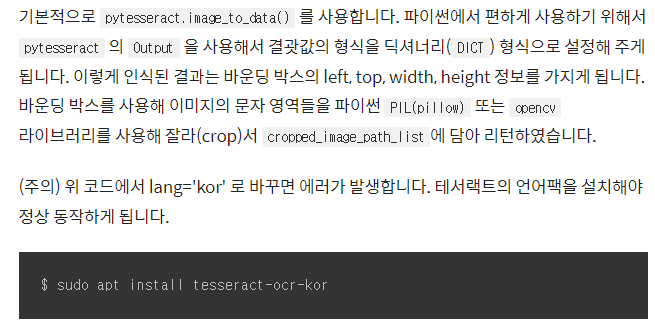

91


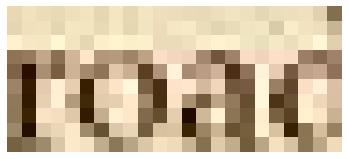

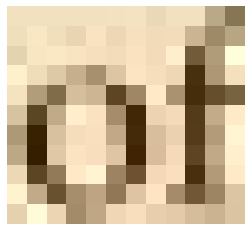

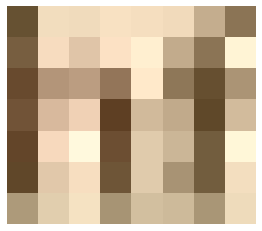

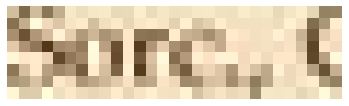

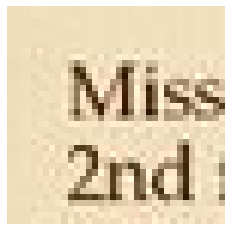

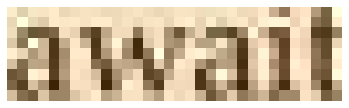

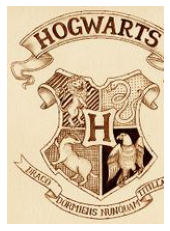

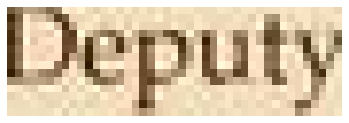

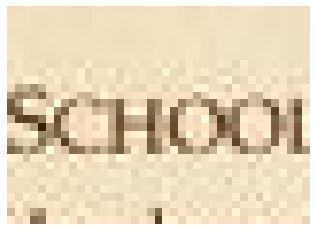

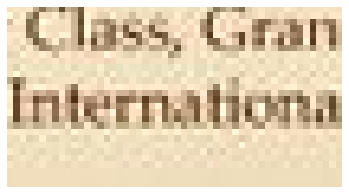

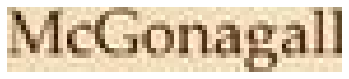

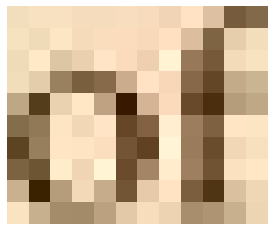

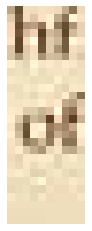

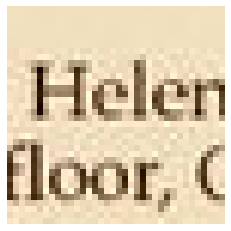

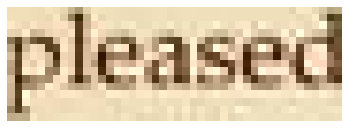

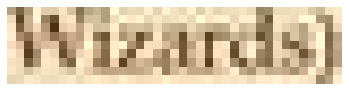

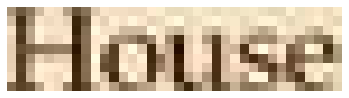

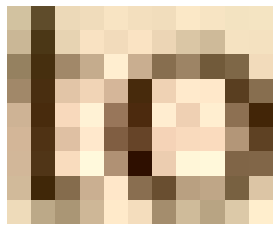

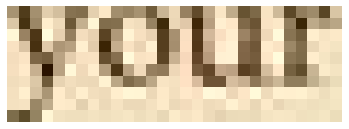

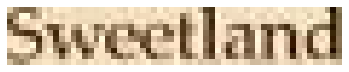

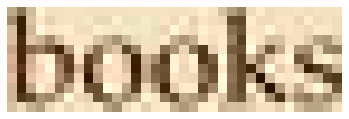

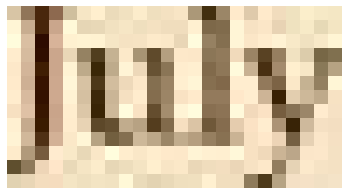

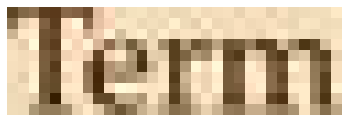

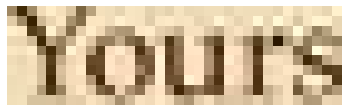

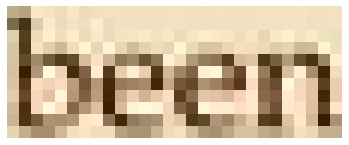

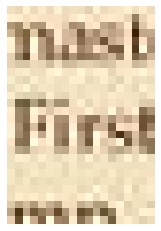

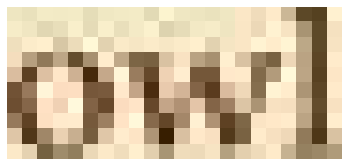

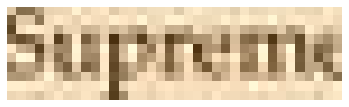

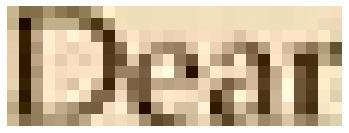

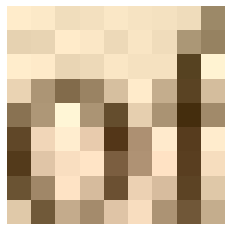

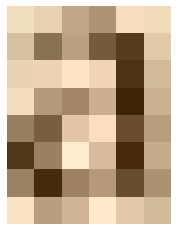

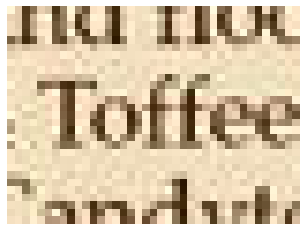

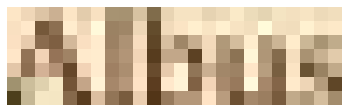

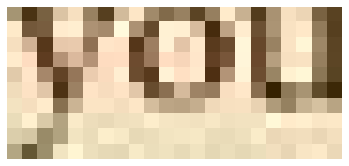

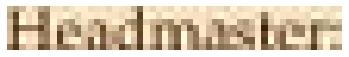

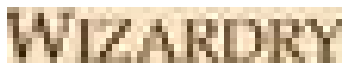

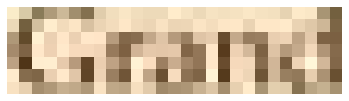

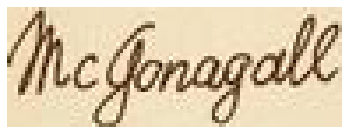

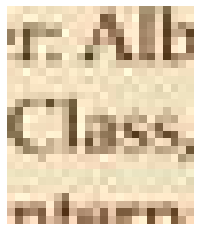

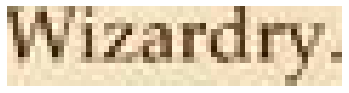

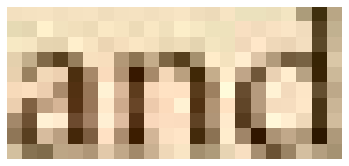

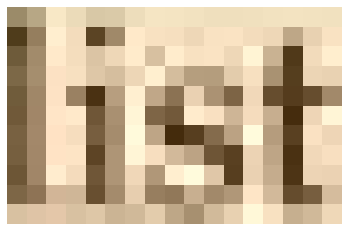

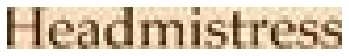

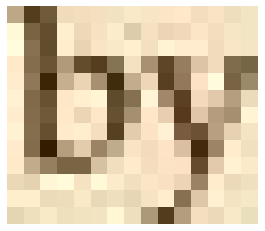

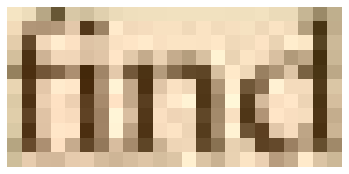

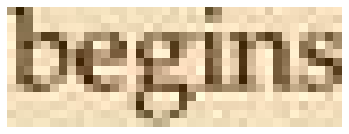

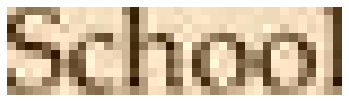

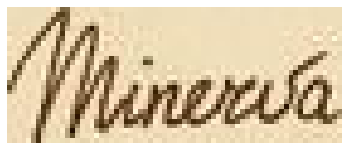

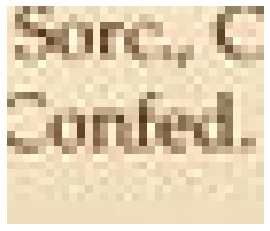

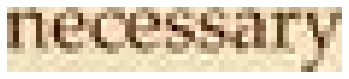

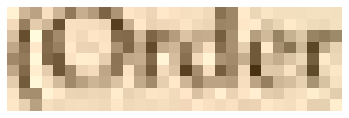

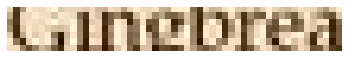

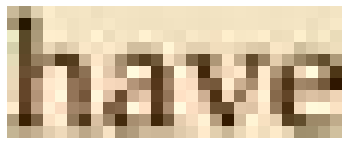

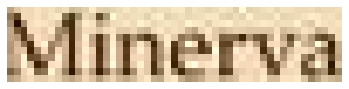

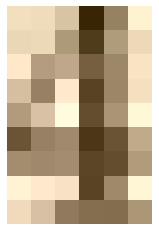

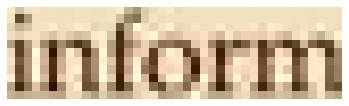

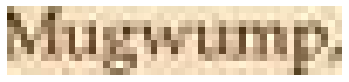

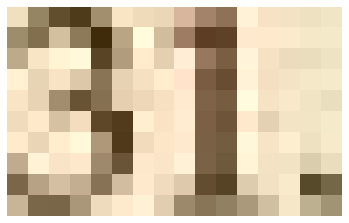

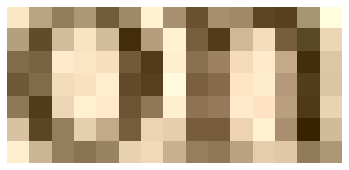

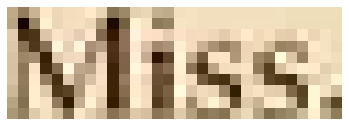

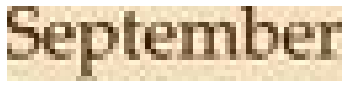

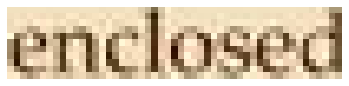

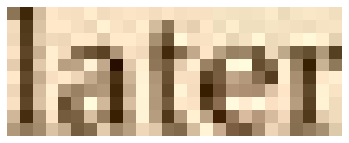

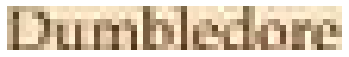

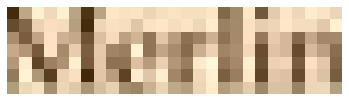

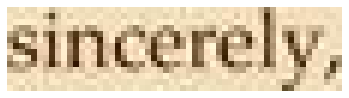

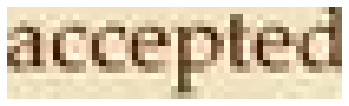

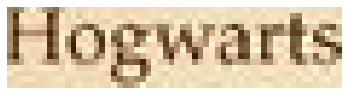

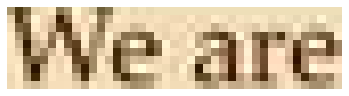

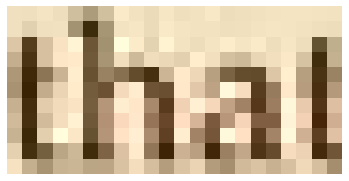

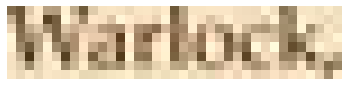

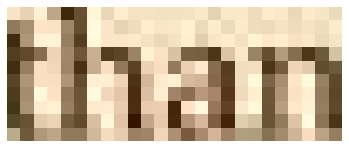

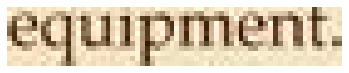

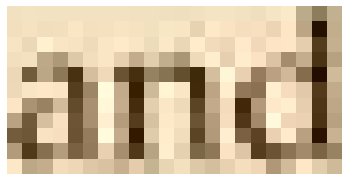

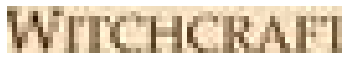

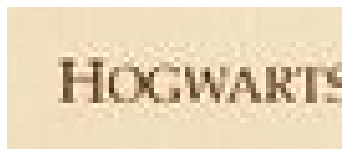

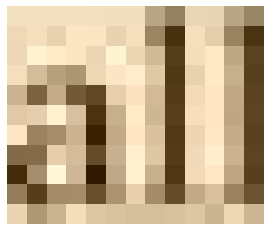

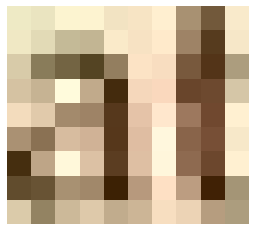

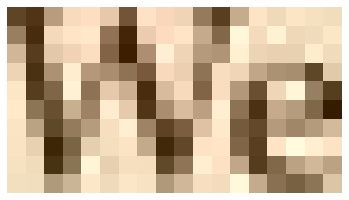

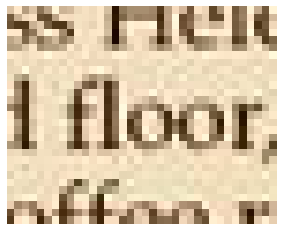

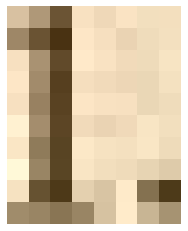

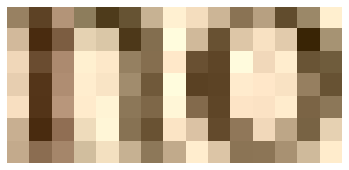

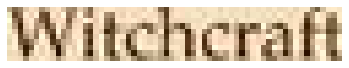

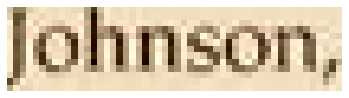

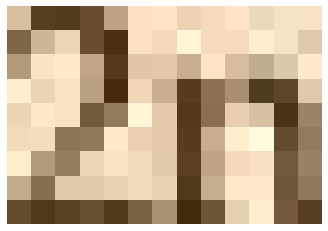

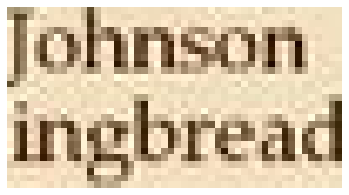

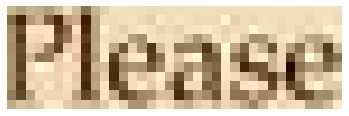

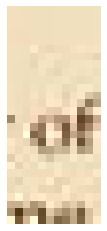

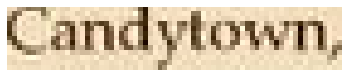

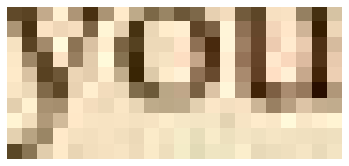

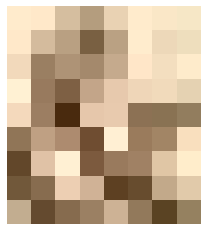

In [44]:
# 문자 위치 검출 잘 되었는지 보기

# folder 안에 있는 crop한 사진 뽑아 리스트화
work_dir = os.getenv('HOME')+'/aiffel/ocr_python/'
file_list = os.listdir(work_dir)
file_list_png = [file for file in file_list if "test_image" not in file and file.endswith('.png')]
print(len(file_list_png))
file_list_png


# 각각의 사진 시각화
for i in file_list_png:
    img_file_path = work_dir + i
    image_pil = Image.open(img_file_path)
    image = np.array(image_pil)
    plt.axis("off")
    plt.imshow(image)
    plt.show()



In [10]:
# 인식 함수
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)


Miss


poo

ry


. ,1vored

Mouse

>


roac

Candytown,

Sweetland

lear

Miss.

johnson,

Ve are

pleased

tO

inform

yOu

that

yuu

have

been

accepted

at

nogwarts

SCHOO!

of

Witchcratt

and

Wizardry.

Please

find

enclosed

cl

‘ist

of

all

Necessary

books

and

equipment.

lerm

begins

Cc Pid

September

i.

Ve

await

YOUR

owl

by

rit)

later

than

July

31.

Yours

sincerely,

Winer

McGonagall

Vinerva

McGonagall

Weputy

headmistress

Hocwarr:

SCHOO!

ryt

WITCHCRAFT

Ay

WIZ ARDRY

ba el rye be beer

A linus

Dombietore

(rcder

of

Vieriin



( arm

sore, &

rit

VWarwck,

Supreme

Mug wtimp,

Internation

ones

i

Wizards)

Done


# 프로젝트 : 다양한 OCR모델 비교하기
주요 라이브러리 버전

In [45]:
import keras_ocr
import pytesseract

print(keras_ocr.__version__)
print(pytesseract.__version__)
# pytesseract는 tesseract-ocr에 종속적입니다. 아래 명령어를 통해 설치해야 할 수도 있습니다.
# !sudo apt install tesseract-ocr

0.8.8
0.3.8


## Step1. 검증용 데이터셋 준비

## Step2. keras-ocr, Tesseract로 테스트 진행

## Step3. 테스트 결과 정리

## Step4. 결과 분석과 결론 제시